L’algorithme des « forêts aléatoires » (ou Random Forest parfois aussi traduit par forêt d’arbres décisionnels) est un algorithme de classification qui réduit la variance des prévisions d’un arbre de décision seul, améliorant ainsi leurs performances. Pour cela, il combine de nombreux arbres de décisions dans une approche de type bagging.

L’algorithme des « forêts aléatoires » a été proposé par Leo Breiman et Adèle Cutler en 2001. Dans sa formule la plus classique, il effectue un apprentissage en parallèle sur de multiples arbres de décision construits aléatoirement et entraînés sur des sous-ensembles de données différents. Le nombre idéal d’arbres, qui peut aller jusqu’à plusieurs centaines voire plus, est un paramètre important : il est très variable et dépend du problème. Concrètement, chaque arbre de la forêt aléatoire est entrainé sur un sous ensemble aléatoire de données selon le principe du bagging, avec un sous ensemble aléatoire de features (caractéristiques variables des données) selon le principe des « projections aléatoires ». Les prédictions sont ensuite moyennées lorsque les données sont quantitatives ou utilisés pour un vote pour des données qualitatives, dans le cas des arbres de classification. L’algorithme des forêts aléatoires est connu pour être un des classifieurs les plus efficaces « out-of-the-box » (c’est-à-dire nécessitant peu de prétraitement des données). Il a été utilisé dans de nombreuses applications, y compris grand public, comme pour la classification d’images de la caméra de console de jeu Kinect* dans le but d’identifier des positions du corps.

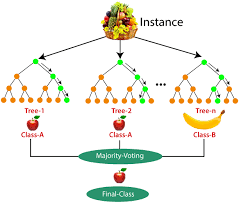

Dans ce notebook, nous aurons besoin de tableaux pour nos données et de graphiques pour la visualisation. 
Par conséquent, nous importons  numpy  et  matplotlib . 
Nous importons pprint pour rendre certaines sorties plus belles.

In [1]:
%matplotlib inline
 
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

Préparation du jeu de données

Nous définissons une fonction pour lire, redimensionner et stocker les données dans un dictionnaire,
contenant les images, les étiquettes, les noms de fichiers originaux et une description.
Les images elles-mêmes sont stockées sous forme de tableaux numpy contenant leurs valeurs RVB. 
Le dictionnaire est enregistré dans un fichier pickle à l'aide de  joblib . 
La structure des données est basée sur celle utilisée pour les  ensembles de données de test dans scikit-learn .

In [12]:
import joblib
from skimage.io import imread
from skimage.transform import resize
 
def resize_all(src, pklname, include, width=150, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1})xray images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
            
            for file in os.listdir(current_path):
                im = imread(os.path.join(current_path, file))
                im = resize(im, (width, height,3)) #[:,:,::-1]
                data['label'].append(subdir)
                data['filename'].append(file)
                data['data'].append(im)
                    
 
        joblib.dump(data, pklname)

In [13]:
data_path = r'C:\Users\smonn\Desktop\T8-AI&BigData_pdf\chest_Xray_3_class\train'
os.listdir(data_path)

['NORMAL', 'PNEUMONIA_BACTERIA', 'PNEUMONIA_VIRUS']

Nous créons maintenant le jeu de données. Cette étape n'est pas nécessaire à chaque fois que nous exécutons le notebook 
car les données sont stockées sous forme de pkl, qui peuvent être chargées directement la prochaine fois.

Nous définissons également la largeur (et la hauteur) à 299 pixels.

In [14]:
base_name = 'x-ray'
width = 299
 
include = {'NORMAL', 'PNEUMONIA_BACTERIA', 'PNEUMONIA_VIRUS'}
 
resize_all(src=data_path, pklname=base_name, width=width, include=include)

NORMAL
PNEUMONIA_BACTERIA
PNEUMONIA_VIRUS


On charge les données du disque et on imprime un résumé.

In [15]:
from collections import Counter
 
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  3974
keys:  ['description', 'label', 'filename', 'data']
description:  resized (299x299)xray images in rgb
image shape:  (299, 299, 3)
labels: ['NORMAL' 'PNEUMONIA_BACTERIA' 'PNEUMONIA_VIRUS']


Counter({'NORMAL': 1300, 'PNEUMONIA_BACTERIA': 1337, 'PNEUMONIA_VIRUS': 1337})

Les images ci-dessous montrent un exemple de chaque classe d'image incluse.

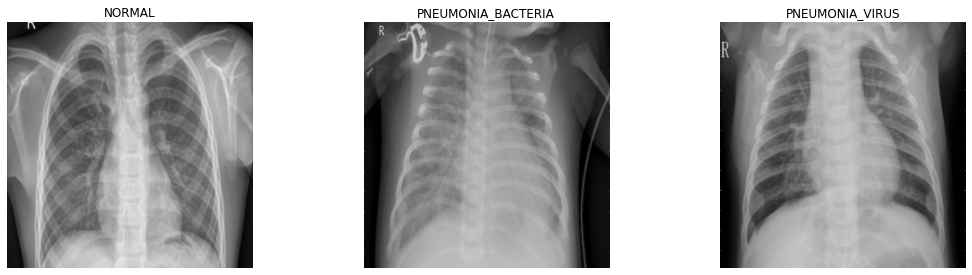

In [16]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

Par convention, nous nommons les données d'entrée  X et le résultat (étiquettes)  y.

In [17]:
X = np.array(data['data'])
y = np.array(data['label'])

Ensuite, nous devons diviser nos données en un ensemble de test et un ensemble d'apprentissage. Nous utilisons la fonction train_test_split de scikit-learn et utilisons 80 % de l'ensemble total pour l'entraînement et le reste pour l'ensemble de test. Dans l'ensemble de données, les photos sont classées, nous ne pouvons donc pas simplement diviser à 80 %.

Si les données sont ordonnées et que nous séparons à une certaine position, nous nous retrouverons avec certaines classes (types) apparaissant dans un seul des deux ensembles. Par exemple, si les pneumonies virale n'apparaissaient que dans le jeu de test. Ce serait un problème, car de cette façon, nous n'entraînerons jamais notre modèle à reconnaître les pneumonies virale, et donc il ne pourra pas les prédire correctement.

Nous pouvons résoudre ce problème en mélangeant les données avant le fractionnement. De cette façon, nous égalisons les distributions dans l'ensemble d'entraînement et de test et les rendons comparables.

La fonction train_test_split dans sklearn fournit un paramètre shuffle pour s'en occuper lors de la scission. Le random_state amorce le brassage de manière à ce qu'il soit aléatoire, mais de manière reproductible.

In [18]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

Pour vérifier que la répartition des photos dans l'ensemble d'entraînement et de test est similaire, examinons le nombre relatif de photos par catégorie.

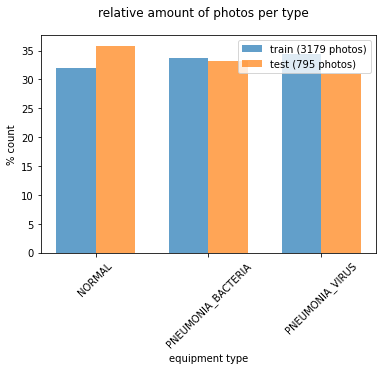

In [19]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

Les distributions ne sont pas parfaitement égales, mais suffisantes pour le moment. Pour une amélioration supplémentaire, nous pourrions également utiliser le paramètre de stratification de train_test_split pour garantir des distributions égales dans l'ensemble d'apprentissage et de test.

Traitement :

Une approche classique de la reconnaissance d'objets est HOG-SVM, qui signifie Histogram of Oriented Gradients and Support Vector Machines. Les HOG sont utilisés pour la réduction des fonctionnalités, en d'autres termes : pour réduire la complexité du problème, tout en conservant autant de variations que possible.

Pour calculer un HOG, une image est découpée en blocs, par exemple de 8 par 8 pixels. Pour chacun de ces blocs, l'amplitude du gradient dans un nombre donné de directions est calculée. Pour une explication détaillée, nous nous référons à  http://www.learnopencv.com/histogram-of-oriented-gradients/ .

Ici, nous nous contenterons de regarder un exemple :

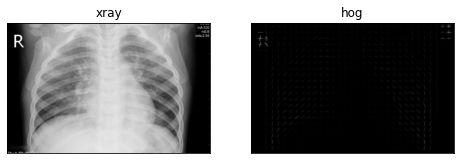

In [22]:
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
 
xray = imread(r"C:\Users\smonn\Desktop\T8-AI&BigData_pdf\chest_Xray_3_class\val\PNEUMONIA_VIRUS\person82_virus_154.jpeg", as_gray=True)

 
# scale down the image to one third
xray = rescale(xray, 1/3, mode='reflect')
# calculate the hog and return a visual representation.
xray_hog, xray_hog_img = hog(
    xray, pixels_per_cell=(14,14), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True, 
    block_norm='L2-Hys')
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]
 
ax[0].imshow(xray, cmap='gray')
ax[0].set_title('xray')
ax[1].imshow(xray_hog_img, cmap='gray')
ax[1].set_title('hog')
plt.show()

In [23]:
print('number of pixels: ', xray.shape[0] * xray.shape[1])
print('number of hog features: ', xray_hog.shape[0])

number of pixels:  139633
number of hog features:  23040


Le nombre de points de données à traiter dans notre modèle a été réduit à ~16 %.

Transformateurs

Lors du calcul de notre HOG, nous avons effectué une transformation. Nous pouvons transformer l'intégralité de notre ensemble de données à l'aide de transformateurs. Ce sont des objets qui prennent le tableau de données, transforment chaque élément et renvoient les données résultantes.

Ici, nous devons convertir les images couleur en niveaux de gris, calculer leurs HOG et enfin mettre les données à l'échelle. Pour cela, nous utilisons trois transformateurs à la suite : RGB2GrayTransformer, HOGTransformer et StandardScaler. Le résultat final est un tableau avec un HOG pour chaque image dans l'entrée.

Scikit-learn est livré avec de nombreux transformateurs intégrés, tels qu'un StandardScaler pour mettre à l'échelle les fonctionnalités et un Binarizer pour mapper les fonctionnalités de chaîne aux fonctionnalités numériques. De plus, il fournit les classes BaseEstimator et TransformerMixin pour faciliter la création de vos propres transformateurs.

Un transformateur personnalisé peut être créé en héritant de ces deux classes et en implémentant une méthode __init__, fit et transform. La classe TransformerMixin fournit la méthode fit_transform, qui combine l'ajustement et la transformation que nous avons implémentés.

Ci-dessous, nous définissons le RGB2GrayTransformer et le HOGTransformer.

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

Pour la compatibilité avec scikit-learn, les méthodes d'ajustement et de transformation prennent à la fois X et y comme paramètres, même si ce n'est pas utilisé ici.

Avec cela, nous sommes prêts à prétraiter nos images RVB en fonctionnalités HOG à l'échelle.

In [25]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(3179, 14400)


Formation

L'étape suivante consiste à former un classifieur. Nous commencerons par Stochastic Gradient Descent (SGD), car il est rapide.

Nous créons d'abord une instance, puis nous appelons la méthode fit en transmettant nos données d'entraînement et nos étiquettes.

In [26]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=42)

Essai

Pour tester le classificateur SGD formé, nous utiliserons notre ensemble de test. Tout d'abord, nous le transformons en utilisant les mêmes transformateurs qu'auparavant. Cependant, nous devons veiller à ce que nos données de test n'influencent pas les transformateurs. Certains transformateurs, comme PCA (Principle Component Analysis), peuvent s'optimiser sur les données avant d'appliquer la transformation. Pour éviter cela, nous appelons transform et non fit_transform sur les données de test.

In [27]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

Ensuite, nous faisons une prédiction pour notre ensemble de tests et examinons les résultats.

In [28]:
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

[ True  True  True False  True False False False  True  True  True  True
  True False  True  True  True False  True  True  True False False  True
  True]

Percentage correct:  71.9496855345912


Matrice de confusion

Qu'en est-il des faux positifs. Pour mieux comprendre les résultats, nous pouvons utiliser une matrice de corrélation. Il s'agit d'un tableau où chaque ligne correspond à une étiquette et chaque colonne à une prédiction.

Nous allons illustrer cela en utilisant une base de données pandas avec des données oui/non.

In [29]:
import pandas as pd

In [30]:
labels = ['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no',  'no', 'no', 'no']
predictions = ['yes', 'yes', 'yes', 'yes', 'no',  'no',  'yes', 'no', 'no', 'no']
 
# put the data in a dataframe for pretty printing
df = pd.DataFrame(
    np.c_[labels, predictions], 
    columns=['true_label', 'prediction']
)
df

,true_label,prediction
0,yes,yes
1,yes,yes
2,yes,yes
3,yes,yes
4,yes,no
5,yes,no
6,no,yes
7,no,no
8,no,no
9,no,no


Pour créer une matrice de confusion, nous utilisons la fonction confusion_matrix de sklearn.metrics. Outre les deux listes que nous avons créées ci-dessus, nous passons également un tableau d'étiquettes avec les valeurs des étiquettes. C'est uniquement pour contrôler l'ordre dans lequel ils apparaissent dans la matrice. Si nous omettons cela, ils apparaîtraient triés par ordre alphabétique. Les colonnes nous donnent les prédictions, tandis que le long de l'index, nous trouvons les vraies étiquettes.

In [31]:
from sklearn.metrics import confusion_matrix
 
label_names = ['yes', 'no']
cmx = confusion_matrix(labels, predictions, labels=label_names)
df = pd.DataFrame(cmx, columns=label_names, index=label_names)
df.columns.name = 'prediction'
df.index.name = 'label'
df

prediction,yes,no
label,,
yes,4,2
no,1,3


La diagonale principale correspond aux prédictions correctes. 
Dans ce cas binaire, les faux positifs apparaissent en dessous et les faux négatifs au-dessus de la diagonale.

Une autre façon de représenter cela est sous la forme d'une image de palette de couleurs.

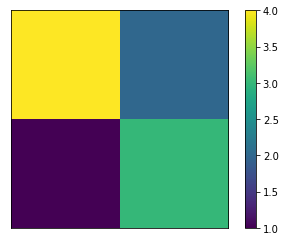

In [32]:
plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar();

La matrice de confusion pour le test SGD est une matrice 8×8. 
Comme ci-dessus, les prédictions correctes apparaissent sur la diagonale principale, 
alors que toutes les valeurs hors diagonale correspondent à des classifications incorrectes.

In [33]:
cmx = confusion_matrix(y_test, y_pred)
cmx

array([[275,   3,   7],
       [ 18, 162,  84],
       [ 33,  78, 135]], dtype=int64)

Les plus grandes valeurs sont sur la diagonale, donc la plupart des prédictions sont correctes, mais il y a des erreurs. 
Pour visualiser cela plus clairement sous forme d'image, nous faisons deux choses. 
Tout d'abord, nous normalisons la matrice à 100, en divisant chaque valeur par la somme de sa ligne 
(c'est-à-dire le nombre d'éléments réels avec une étiquette spécifique). 
Deuxièmement, nous fixons la diagonale principale à 0 afin de nous concentrer sur les mauvaises prédictions.


 ['NORMAL', 'PNEUMONIA_BACTERIA', 'PNEUMONIA_VIRUS']


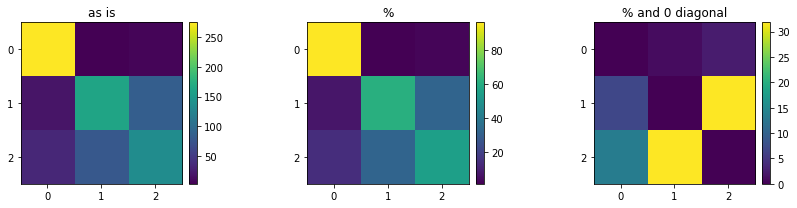

In [34]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
def plot_confusion_matrix(cmx, vmax1=None, vmax2=None, vmax3=None):
    cmx_norm = 100*cmx / cmx.sum(axis=1, keepdims=True)
    cmx_zero_diag = cmx_norm.copy()
 
    np.fill_diagonal(cmx_zero_diag, 0)
 
    fig, ax = plt.subplots(ncols=3)
    fig.set_size_inches(12, 3)
    [a.set_xticks(range(len(cmx)+1)) for a in ax]
    [a.set_yticks(range(len(cmx)+1)) for a in ax]
         
    im1 = ax[0].imshow(cmx, vmax=vmax1)
    ax[0].set_title('as is')
    im2 = ax[1].imshow(cmx_norm, vmax=vmax2)
    ax[1].set_title('%')
    im3 = ax[2].imshow(cmx_zero_diag, vmax=vmax3)
    ax[2].set_title('% and 0 diagonal')
 
    dividers = [make_axes_locatable(a) for a in ax]
    cax1, cax2, cax3 = [divider.append_axes("right", size="5%", pad=0.1) 
                        for divider in dividers]
 
    fig.colorbar(im1, cax=cax1)
    fig.colorbar(im2, cax=cax2)
    fig.colorbar(im3, cax=cax3)
    fig.tight_layout()
     
plot_confusion_matrix(cmx)
 
# the types appear in this order
print('\n', sorted(np.unique(y_test)))

Optimisation :

Un score de 71.94 % n'est pas mauvais pour une première tentative, mais il peut très probablement être amélioré. 
Comme nous avons déjà un tas de paramètres avec lesquels jouer, ce serait bien d'automatiser l'optimisation. 
Dans la partie suivante, nous allons mettre en place un pipeline qui prétraite les données, 
entraîne le modèle et nous permet de jouer plus facilement avec les paramètres.

La méthode d'ajustement du pipeline prend les données d'entrée et les transforme par étapes en appelant séquentiellement la méthode fit_transform de chaque transformateur. Les données sont transmises de la sortie à l'entrée jusqu'à ce qu'elles atteignent la fin ou l'estimateur s'il y en a un. Lorsque le dernier élément du pipeline est un estimateur, sa méthode d'ajustement est appelée pour entraîner le modèle à l'aide des données transformées.

L'objet résultant peut être utilisé directement pour faire des prédictions. Les données de test sont transmises à la méthode de prédiction, qui appelle les méthodes de transformation, suivies de la prédiction à l'étape finale.

Une exécution avec notre système montre que le résultat du pipeline est identique au  résultat que nous avions auparavant .

In [35]:
from sklearn.pipeline import Pipeline
from sklearn import svm
 
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))


Percentage correct:  71.9496855345912


Grille de recherche

Un énorme avantage ici est qu'en utilisant notre pipeline, nous pouvons optimiser à la fois les transformations et le classificateur en une seule procédure. De plus, au lieu de modifier manuellement les paramètres, nous utiliserons GridSearchCV. Nous définissons d'abord une grille de paramètres, comme indiqué dans la cellule ci-dessous.

Les transformateurs et les estimateurs sont indiqués par leur nom, comme « classifier ». 
Leurs paramètres sont indiqués par 'name__parameter'. Notre grille de paramètres se compose de deux dictionnaires. 
Dans le premier, nous essayons d'améliorer le HOGTransformer. Dans le second, nous testons SGD vs SVM. 
GridSearchCV vérifiera toutes les combinaisons dans chaque dictionnaire, nous aurons donc 2 * 2 * 3 + 2 = 14, au total. 
Étant donné que le prétraitement optimal peut varier selon le modèle, il est souvent judicieux de les rechercher ensemble pour trouver l'optimum global. 

Ainsi, une meilleure grille serait celle où les paramètres hogify et classify sont variés ensemble (en les plaçant dans un seul dictionnaire).

In [36]:
from sklearn.model_selection import GridSearchCV
 
param_grid = [
    {
        'hogify__orientations': [8, 9],
        'hogify__cells_per_block': [(2, 2), (3, 3)],
        'hogify__pixels_per_cell': [(8, 8), (10, 10), (12, 12)]
    },
    {
        'hogify__orientations': [8],
         'hogify__cells_per_block': [(3, 3)],
         'hogify__pixels_per_cell': [(8, 8)],
         'classify': [
             SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
             svm.SVC(kernel='linear')
         ]
    }
]

Ensuite, nous créons un objet GridSearchCV, en passant le pipeline et la grille de paramètres. 
Nous utilisons cv=3. Ce paramètre configure la validation croisée. Cela signifie que l'ensemble de données est divisé en plis 
(3 dans ce cas) et que plusieurs cycles d'entraînement sont effectués. 
Dans chaque run, un pli est utilisé pour la validation et les autres pour l'entraînement. 
De cette façon, le modèle peut être validé et amélioré par rapport à une partie des données d'apprentissage, sans toucher aux données de test. 
Pour le paramètre final, le score, nous utilisons la "précision", le pourcentage de vrais pronostics positifs. 
Dans d'autres cas, il peut être plus utile d'utiliser les faux positifs de contrôle ou une autre statistique.

Le paramètre n_jobs spécifie le nombre de travaux que nous souhaitons exécuter en parallèle. 
Si nous définissons sa valeur sur -1 pour alors nous utiliserons tous les cœurs disponibles. 
Cela fonctionne sous Linux et éventuellement OSX, mais pas sous MS Windows.

Pour paralléliser sous Windows, il est nécessaire d'exécuter ce code depuis un script, à l'intérieur d'une clause if __name__ == '__main__'. Des explications supplémentaires peuvent être trouvées dans la  documentation de joblib.

In [38]:
grid_search = GridSearchCV(HOG_pipeline, 
                           param_grid, 
                           cv=3,
                           n_jobs=1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
 
grid_res = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


Lorsque la recherche de grille est terminée, le modèle sera entraîné une dernière fois, en utilisant l'ensemble d'entraînement complet et les paramètres optimaux. Nous pouvons vider l'objet résultant dans un fichier pickle et le charger lorsque nous voulons l'utiliser. Nous pouvons également utiliser diverses méthodes pour fouiller dans les résultats et les scores lors de la recherche.

In [39]:
# save the model to disk
joblib.dump(grid_res, 'hog_sgd_model.pkl');

In [40]:
# description of the best performing object, a pipeline in our case.
grid_res.best_estimator_

Pipeline(steps=[('grayify', RGB2GrayTransformer()),
                ('hogify', HogTransformer(orientations=8)),
                ('scalify', StandardScaler()),
                ('classify', SVC(kernel='linear'))])

In [42]:
Pipeline(steps=[('grayify', RGB2GrayTransformer()),
                ('hogify', HogTransformer(orientations=8)),
                ('scalify', StandardScaler()),
                ('classify', svm.SVC(kernel='linear'))])

Pipeline(steps=[('grayify', RGB2GrayTransformer()),
                ('hogify', HogTransformer(orientations=8)),
                ('scalify', StandardScaler()),
                ('classify', SVC(kernel='linear'))])

__On peut aussi exécuter grid_res.cv_results_ pour obtenir un journal détaillé de la recherche de grille.

In [43]:
# the highscore during the search
grid_res.best_score_

0.7159531063481035

In [44]:
pp.pprint(grid_res.best_params_)

{   'classify': SVC(kernel='linear'),
    'hogify__cells_per_block': (3, 3),
    'hogify__orientations': 8,
    'hogify__pixels_per_cell': (8, 8)}


Comme le nombre d'exécutions a tendance à exploser rapidement lors d'une recherche de grille, il est parfois utile d'utiliser RandomizedSearchCV. Cela fonctionne de la même manière que la recherche de grille, mais sélectionne un nombre spécifié (n_iter) d'ensembles aléatoires de paramètres dans la grille. Cela peut être un bon moyen d'obtenir une estimation approximative des paramètres optimaux, avant d'utiliser un GridSearchCV pour un réglage fin.

Pour en revenir à nos résultats GridSearchCV, nos meilleurs résultats ont été obtenus avec un SVM linéaire. En tant que test final, nous utilisons le modèle pour faire des prédictions pour notre ensemble de tests, comme nous l'avons fait ci-dessus.

In [45]:
best_pred = grid_res.predict(X_test)
print('Percentage correct: ', 100*np.sum(best_pred == y_test)/len(y_test))

Percentage correct:  73.58490566037736


La précision est passée de 71.94% à 73.58%. Pour en savoir plus, nous pouvons comparer les matrices de confusion avant et après optimisation. Notez que les gammes de couleurs sont définies sur la plus grande des deux, à des fins de comparaison.

In [46]:
cmx_svm = confusion_matrix(y_test, best_pred)

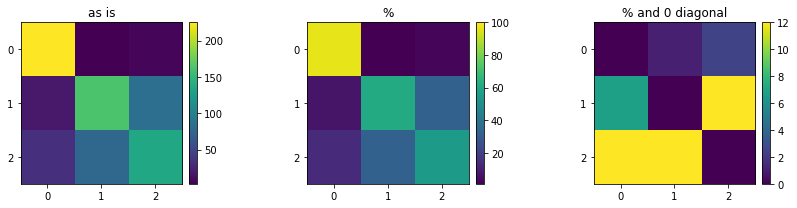

In [47]:
plot_confusion_matrix(cmx, vmax1=225, vmax2=100, vmax3=12)

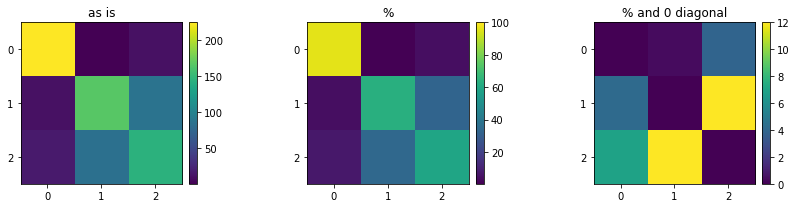

In [48]:
plot_confusion_matrix(cmx_svm, vmax1=225, vmax2=100, vmax3=12)

À l'extrême droite, nous pouvons voir où des améliorations ont eu lieu. Nous pouvons maintenant essayer de rechercher des problèmes spécifiques dans les données ou effectuer une extraction de caractéristiques pour une amélioration supplémentaire. Heureusement, avec la boîte à outils que nous avons construite, nous pouvons laisser l'ordinateur faire une bonne partie de ce travail pour nous.

Conclusion :

En conclusion, nous avons construit un modèle de base pour classer les images en fonction de leurs caractéristiques HOG. De plus, nous avons paramétré nos outils pour améliorer systématiquement le modèle de manière automatisée. Et surtout, cette méthodologie est générique et peut être appliquée à toutes sortes de problèmes d'apprentissage automatique.